# Publishing Figures - Multi Kappa
This obtains all figures for a combining all simulations of differing optical depth that require the surface and free troposphere variables.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import clausius_clapeyron_factor, sphum_sat, moist_static_energy, lapse_moist
from isca_tools.utils.constants import L_v, c_p
from isca_tools.utils import area_weight_mean_lat, area_weighting
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory
from isca_tools.papers.byrne_2021 import get_quant_ind
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import os
import numpy_indexed
from scipy.stats import median_abs_deviation
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
from isca_tools.utils.radiation import frierson_atmospheric_heating
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2023-09-06 09:18:57,264 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset
var_keep = ['temp', 'sphum', 'height']
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
# exp_names = exp_names[2:-1]     # get rid of coldest 2 and warmest simulation as don't work well
n_exp = len(exp_names)
ds_base = []
albedo = []
tau_sw = []
tau_lw = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])
    ds_base += [ds_use]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
tau_lw = np.asarray(tau_lw)

100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


## Get datasets
Get one dataset for each $\kappa$, combining the desired latitudes: `ds_all`. This combines all or just the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [4]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)
use_time_start = 360*2

# Chose whether to only consider summer days for mean or all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH 

ds = {'all': [], 'summer': []}  # need both all and summer day dataset
with tqdm(total=n_exp*2, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds_base[i].sel(pfull=[np.inf, pressure_ft], method='nearest').sel(time=slice(use_time_start, np.inf))
        ds['all'] += [ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1)).load()]
        pbar.update(1)
        ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))  
        ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0)) 
        # Combine hemispheres and average over longitude, time and latitude.
        ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds['summer'] += [ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1)).load()]
        pbar.update(1)
p_surface = float(ds['all'][0].pfull[0]) * 100
pressure_ft_actual = float(ds['all'][0].pfull[-1]) * 100       # Actual pressure of free troposphere (Pa)

100%|██████████| 16/16 [05:29<00:00, 20.57s/it]


In [5]:
# Get values averaged around a surface temperature percentile, rather than exactly on it.
quant_all = np.asarray([95])     # only considering high percentiles
n_quant = len(quant_all)
quant_alpha = [1] if n_quant==1 else [0.1+i*(0.9/n_quant) for i in range(n_quant)]
n_lat = ds['all'][0].lat.shape[0]
n_pressure = ds['all'][0].pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds['all'][0].lat))     # latitude area weighting is just the cosine

# For averages, need both summer and all average
temp_median = {key: np.zeros((n_exp, n_pressure, n_lat)) for key in ['all', 'summer']}
temp_mean = {key: np.zeros((n_exp, n_pressure, n_lat)) for key in ['all', 'summer']}
mse_mean = {key: np.zeros((n_exp, n_pressure, n_lat)) for key in ['all', 'summer']}
# In free troposphere, this is saturated MSE.

# Note the quant3_type doesn't make much difference and only really makes a difference in the tropics
# where the equivalence of the temperature and moist static energy percentiles is not as valid.
# quant3_type = 'temp'            # Take percentile to be temperature percentile      (this is legacy, what I was doing previously)
quant3_type = 'mse'             # Take percentile to be of near-surface mse (think this is correct version of theory)
# All quantiles are over all days
temp_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant)) 
mse_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant))      # as function of temperature quantile
mse_quant2 = np.zeros((n_exp, n_lat, n_quant))      # as function of mse quantile
with tqdm(total=n_exp*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for key in ['summer', 'all']:      
            # need 'all' last so mse is correct for quantile computation
            mse = moist_static_energy(ds[key][i].temp[0], ds[key][i].sphum[0], ds[key][i].height[0])
            mse_ft = moist_static_energy(ds[key][i].temp[-1], sphum_sat(ds[key][i].temp[-1], pressure_ft_actual), ds[key][i].height[-1])
            mse_mean[key][i, 0] = mse.mean(dim='lon_time')
            mse_mean[key][i, 1] = mse_ft.mean(dim='lon_time')
            temp_mean[key][i] = ds[key][i].temp.mean(dim='lon_time')
            temp_median[key][i] = ds[key][i].temp.median(dim='lon_time')
        mse_quant2[i] = mse.quantile(quant_all/100, dim='lon_time', keep_attrs=True).transpose()
        for k in range(n_lat):
            for j, quant in enumerate(quant_all):
                if quant3_type == 'temp':
                    use_ind = get_quant_ind(ds['all'][i].temp[0, k], quant, 0.5, 0.5)
                elif quant3_type == 'mse':
                    use_ind = get_quant_ind(mse[k], quant, 0.5, 0.5)
                else:
                    raise ValueError('quant3_type not valid')
                temp_quant3[i, :, k, j] = ds['all'][i].temp[:, k, use_ind].mean(dim='lon_time')
                mse_quant3[i, 0, k, j] = mse[k, use_ind].mean(dim='lon_time')       # this is the same as mse_quant2 if quant3_type == mse
                mse_quant3[i, 1, k, j] = mse_ft[k, use_ind].mean(dim='lon_time')
                pbar.update(1)

100%|██████████| 512/512 [00:18<00:00, 28.00it/s]


## $\lambda$ Decompostion
### Combine latitudes
Here, I break down the $\lambda=1$ approximation into three different factors. $\lambda_1$ represents CQE on the $x$ percentile day. $\lambda_2$ represents the weak temperature gradient approximation and $\lambda_3$ represents CQE on the mean day.

Note the black line below differs from actual $\lambda$ because here I am plotting it as a function of near-surface temperature percentile, whereas for lambda plot in `surface/single_kappa` notebook, I plot it as a function of near-surface MSE percentile. I.e. the x-axis are different.

In [6]:
def get_gradient(y, x_var, ref_ind):
    """
    Gets gradient of y vs x_var across experiments, with best fit line forced to go through 
    y[ref_ind] at x_var[ref_ind].

    Args:
        y: [n_exp]
        x_var: [n_exp]
        ref_ind: int

    Returns:
        int
            Gradient
        [n_exp]
            Predicted y at each x
    """
    fit_func = lambda x, m: y[ref_ind] + m*(x-x_var[ref_ind])     # Straight line through the ref point
    param = scipy.optimize.curve_fit(fit_func,x_var, y)[0]
    return param, fit_func(x_var, param)

tau_lw_ref = 1
tau_ref_ind = np.where(tau_lw==tau_lw_ref)[0][0]
sf_tau_use = [np.where(tau_lw<=np.inf)[0], np.where(tau_lw<=1)[0], np.where(tau_lw>=1)[0]]
sf_tau_ref = [1, 1, 1]      # one for each set
sf_titles = ['All $\kappa$', f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$', f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$']
n_sf = len(sf_tau_use)

In [7]:
def get_lambda_2_0(temp_quant_ft, temp_mean_ft):
    num = c_p + L_v * clausius_clapeyron_factor(temp_quant_ft, pressure_ft_actual) * sphum_sat(temp_quant_ft, pressure_ft_actual)
    denom = c_p + L_v * clausius_clapeyron_factor(temp_mean_ft, pressure_ft_actual) * sphum_sat(temp_mean_ft, pressure_ft_actual)
    return num/denom

# lambda_2_0 = {key: (c_p + L_v * clausius_clapeyron_factor(temp_quant3[0, 1], pressure_ft_actual) *
#               sphum_sat(temp_quant3[0, 1], pressure_ft_actual)) / 
#                    np.expand_dims(c_p + L_v * clausius_clapeyron_factor(temp_mean[key][0, 1], pressure_ft_actual) * 
#                                   sphum_sat(temp_mean[key][0, 1], pressure_ft_actual), axis=-1) for key in ds}
# # lambda_2_0 = lambda_2_0 + np.expand_dims((9.81*ds_all[0].height[1].mean(dim='lon_time')/temp_mean[0, 1]) / (c_p + L_v * clausius_clapeyron_factor(temp_mean[0, 1], pressure_ft_actual) * sphum_sat(temp_mean[0, 1], pressure_ft_actual)), axis=-1)
# # lambda_z = temp_quant3[0, 1]*9.81*np.expand_dims(ds_all[0].height[1].mean(dim='lon_time'), axis=-1)/np.expand_dims(temp_mean[0, 1]**2*(c_p + L_v * clausius_clapeyron_factor(temp_mean[0, 1], pressure_ft_actual) * sphum_sat(temp_mean[0, 1], pressure_ft_actual)), axis=-1)
# lambda_2_delta = {key: (temp_quant3[1]-temp_quant3[0])[1]/np.expand_dims(temp_mean[key][1]-temp_mean[key][0], axis=-1)[1] for key in ds}

In [8]:
lambda_1 = np.zeros((n_sf, n_lat, n_quant))
lambda_2 = {key: np.zeros((n_sf, n_lat, n_quant)) for key in ds}
lambda_3 = {key: np.zeros((n_sf, n_lat)) for key in ds}
lambda_full = {key: np.zeros((n_sf, n_lat, n_quant)) for key in ds}
labels = ['$\lambda(x) = \lambda_1(x) \lambda_2(x) / \overline{\lambda_1}$',
          '$\lambda_1(x)$',
          '$\lambda_2(x)$',
          '$\overline{\lambda_1}$']

lambda_2_0 = {key: np.zeros((n_exp, n_lat, n_quant)) for key in ds}
lambda_2_delta = {key: np.zeros((n_sf, n_lat, n_quant)) for key in ds}
for k in range(n_sf):
    sf_tau_ref_ind = np.where(tau_lw[sf_tau_use[k]]==sf_tau_ref[k])[0]
    for i in range(n_lat):
        for key in ds:
            lambda_3[key][k, i] = get_gradient(mse_mean[key][sf_tau_use[k], 0, i], mse_mean[key][sf_tau_use[k], 1, i], sf_tau_ref_ind)[0]
        for j in range(n_quant):
            lambda_1[k, i, j] = get_gradient(mse_quant3[sf_tau_use[k], 0, i, j], mse_quant3[sf_tau_use[k], 1, i, j], sf_tau_ref_ind)[0]
            for key in ds:
                lambda_2[key][k, i, j] = get_gradient(mse_quant3[sf_tau_use[k], 1, i, j], 
                                                      mse_mean[key][sf_tau_use[k], 1, i], sf_tau_ref_ind)[0]
                lambda_full[key][k, i, j] = get_gradient(mse_quant2[sf_tau_use[k], i, j], 
                                                         mse_mean[key][sf_tau_use[k], 0, i], sf_tau_ref_ind)[0]
                lambda_2_delta[key][k, i, j] = get_gradient(temp_quant3[sf_tau_use[k], 1, i, j], temp_mean[key][sf_tau_use[k], 1, i],
                                                            sf_tau_ref_ind)[0]
                # Just take compute lambda_2_0 for each kappa value
                lambda_2_0[key][:, i, j] = get_lambda_2_0(temp_quant3[:, 1, i, j], temp_mean[key][:, 1, i])

### Check that $\lambda = \lambda_1 \lambda_2 / \lambda_3$
In the plot below, I see if the individual $\lambda$ values computed above combine to give the overall $\lambda$ as expected.

You would expect them to differ where the temperature and MSE quantiles don't match up (if `quant3_type=temp`). This appears to be more the case for the warmer simulations, especially in the subtropics.

For `quant3_type=mse`, they match up well though.

In [9]:
def abs_lat_av(var):
    # averages across indices with the same absolute latitude
    var_av = np.zeros(int(len(var)/2))
    for i in range(len(var_av)):
        var_av[i] = np.mean([var[i], var[-1-i]])
    return var_av[::-1]     # invert order so latitude is increasing
lat_plot = ds['all'][0].lat[int(n_lat/2):]

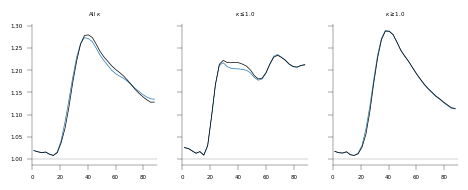

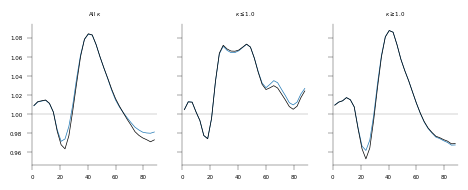

In [10]:
# One Figure for lambda relative to overall average and one relative to summer average.
for key in ds:
    fig, ax = plt.subplots(1,3, figsize=(width['two_col'], width['two_col']/ar/(0.75*3)), sharey=True, sharex=True)
    for i in range(n_sf):
        for j in range(n_quant):
            ax[i].plot(lat_plot, abs_lat_av(lambda_full[key][i, :, j]), alpha=quant_alpha[j], color=default_colors[0])
            ax[i].plot(lat_plot, abs_lat_av(lambda_1[i, :, j]*lambda_2[key][i, :, j]/lambda_3[key][i]), 
                       alpha=quant_alpha[j], color='k')
        ax[i].hlines(1, -90, 90, color='k', alpha=0.5, lw=ax_linewidth)
        ax[i].set_title(sf_titles[i])
    ax[0].set_xlim(0, 90)

## $\lambda$ Decompostion
Here, I break down the $\lambda=1$ approximation into three different factors. $\lambda_1$ represents CQE on the $x$ percentile day. $\lambda_2$ represents the weak temperature gradient approximation and $\lambda_3$ represents CQE on the mean day.

Note the black line below differs from actual $\lambda$ because here I am plotting it as a function of near-surface temperature percentile, whereas for lambda plot in `surface/single_kappa` notebook, I plot it as a function of near-surface MSE percentile. I.e. the x-axis are different.

This is investigated above.

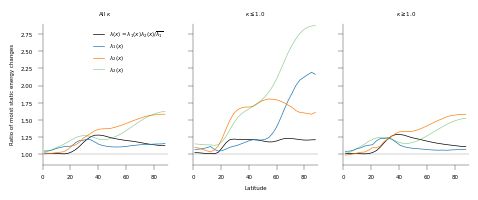

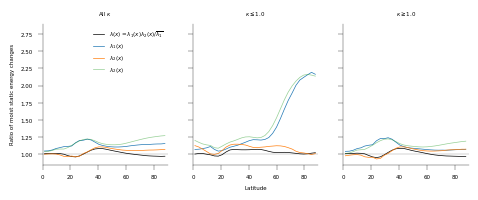

In [17]:
# Using lambda relative to mean overall then mean summer day
save_lambda_decomp_lat_fig = {'all':False, 'summer': False}
fig_lambda_decomp = {}
for key in ds:
    fig, ax = plt.subplots(1,3, figsize=(width['two_col'], width['two_col']/ar/(0.75*3)), sharey=True, sharex=True)
    for i in range(n_sf):
        for k, var in enumerate([lambda_1[i]*lambda_2[key][i]/np.expand_dims(lambda_3[key][i], axis=-1), lambda_1[i], lambda_2[key][i]]):
            use_color = 'k' if k == 0 else default_colors[k-1]
            for j in range(n_quant):
                ax[i].plot(lat_plot, abs_lat_av(var[:, j]), alpha=quant_alpha[j], color=use_color, label=labels[k] if j==n_quant-1 else None)
        ax[i].plot(lat_plot, abs_lat_av(lambda_3[key][i]), color=default_colors[2], alpha=0.5, label=labels[2])
        ax[i].hlines(1, -90, 90, color='k', alpha=0.5, lw=ax_linewidth)
        ax[i].set_xlim(0, 90)
        ax[0].legend()
        ax[1].set_xlabel('Latitude')
        ax[0].set_ylabel('Ratio of moist static energy changes')
        ax[i].set_title(sf_titles[i])
        # ax.set_title('$x=90, 95, 99$')
        # ax.set_title('$x=10, 5, 1$')
        ax[0].set_ylim(0.85,2.9)
        if (save_fig or save_lambda_decomp_lat_fig[key]):
            fig.savefig(f"/Users/joshduffield/Desktop/multi_kappa_lambda_decomp_lat_{key}.pdf",
                        dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

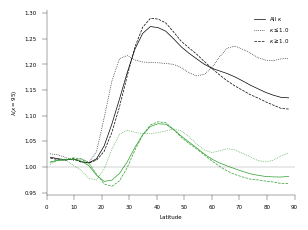

In [36]:
save_lambda_comp_fig = False

linestyles_sf = ['-', ':', '--']
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for key in ds:
    for i in range(n_sf):
        for j in range(n_quant):
            ax.plot(lat_plot, abs_lat_av(lambda_full[key][i, :, j]), alpha=quant_alpha[j], color='k' if key=='all' else default_colors[2], 
                    linestyle=linestyles_sf[i], label=sf_titles[i] if j==n_quant-1 and key=='all' else None)
ax.hlines(1, -90, 90, color='k', alpha=0.5, lw=ax_linewidth)
ax.legend()
ax.set_xlim(0,90)
ax.set_xlabel('Latitude')
ax.set_ylabel(f'$\lambda(x={quant_all[0]})$')
if (save_fig or save_lambda_comp_fig):
    fig.savefig(f"/Users/joshduffield/Desktop/multi_kappa_lambda_summer_lat_{key}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### $\lambda_2$ Decomposition
$\lambda_2(x) = \delta h_{FT, sat}(x) / \delta \overline{h}_{FT, sat}$ can be split up into a product of two terms:
$$\lambda_2(x) = \frac{c_p+L_v\alpha(T_{FT}(x))q^*(T_{FT}(x))}{c_p+L_v\alpha(\overline{T_{FT}})q^*(\overline{T_{FT}})} \times
\frac{\delta T_{FT}(x)}{\delta \overline{T_{FT}}$$
The first term being just evaluated at the historical simulation, and the second incorporating temperature changes. This equation assumes no changes to the geopotential height term, but in zhang 2023, these can be related to temperature as well.
I label these contributions as $\lambda_{2_0}$ and $\lambda_{2_{\delta}}$ respectively.

The black and blue lines below differ, indicating that the geopotential height or potentialy squared temperature, $\delta T^2$ terms may be important.

I find $\lambda_{2_0}$ by just taking the mean of all $\lambda_{2_0}$ values in the $\kappa$ range being considered.

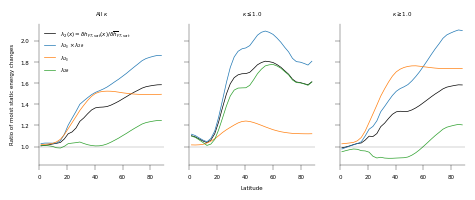

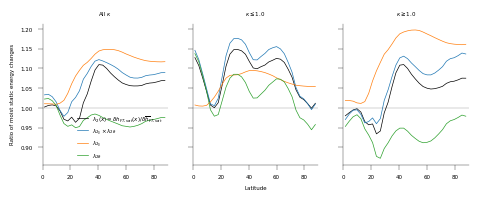

In [12]:
labels_lambda2 = ['$\lambda_2(x) = \delta h_{FT, sat}(x) / \delta \overline{h}_{FT, sat}$',
                  '$\lambda_{2_0} \\times \lambda_{2\delta}$', '$\lambda_{2_0}$', '$\lambda_{2\delta}$']

# Fot lambda_2_0, take mean over all values in range of kappa considered.
save_lambda2_decomp_lat_fig = {'all': False, 'summer': False}
for key in ds:
    fig, ax = plt.subplots(1,3, figsize=(width['two_col'], width['two_col']/ar/(0.75*3)), sharey=True, sharex=True)
    for i in range(n_sf):
        for k, var in enumerate([lambda_2[key][i], np.mean(lambda_2_0[key][sf_tau_use[i]], axis=0) * lambda_2_delta[key][i],
                                 np.mean(lambda_2_0[key][sf_tau_use[i]], axis=0), lambda_2_delta[key][i]]):
            use_color = 'k' if k == 0 else default_colors[k-1]
            for j in range(n_quant):
                ax[i].plot(lat_plot, abs_lat_av(var[:, j]), alpha=quant_alpha[j], color=use_color, 
                           label=labels_lambda2[k] if j==n_quant-1 else None)
        ax[i].hlines(1, -90, 90, color='k', alpha=0.5, lw=ax_linewidth)
        ax[i].set_title(sf_titles[i])
    ax[0].set_xlim(0, 90)
    ax[0].legend()
    ax[1].set_xlabel('Latitude')
    ax[0].set_ylabel('Ratio of moist static energy changes')
    if (save_fig or save_lambda2_decomp_lat_fig[key]):
        fig.savefig(f"/Users/joshduffield/Desktop/multi_kappa_lambda2_decomp_lat_{key}.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Theory as function of latitude
Below I compare how the theory based on overall mean, based on summer mean and with/without the $\lambda_{2_0}$ stuff compares.

In [13]:
# Obtain surface quantities required for theories
sphum_mean = {key: np.zeros((n_exp, n_lat)) for key in ds}
# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = np.zeros((n_exp, n_lat, n_quant))
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant2 = np.zeros((n_exp, n_lat, n_quant))

for i in tqdm(range(n_exp)):
    for key in ['summer', 'all']:
        # need 'all' last so full dataset used to compute quantiles
        ds_use = ds[key][i].sel(pfull=p_surface/100)
        sphum_mean[key][i] = ds_use.sphum.mean(dim='lon_time')
    temp_quant2[i] = ds_use.temp.quantile(quant_all/100, dim='lon_time', keep_attrs=True).transpose()
    sphum_quant2[i] = ds_use.sphum.quantile(quant_all/100, dim='lon_time', keep_attrs=True).transpose()

temp_diff_theory = {key: {method: np.zeros((n_exp-1, n_lat, n_quant)) for method in ['linear', 'lambda_2']} for key in ds}
for key in ds:
    for method in temp_diff_theory['all']:
        for i in range(n_exp-1):
            for j in range(n_lat):
                temp_diff_theory[key][method][:, j] = \
                    get_delta_temp_quant_theory(temp_mean[key][:, 0, j], sphum_mean[key][:, j], temp_quant2[:, j], sphum_quant2[:, j],
                                                p_surface, const_rh=False, 
                                                delta_mse_ratio=lambda_2_0[key][:-1, j] if 'lambda' in method else None,
                                                taylor_level='linear_rh_diff')

100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


In [14]:
# theory adds the theoretical temp_diff to theory prediction of previous kappa so errors accumulate
# The value for the coldest kappa is taken as the actual value.
temp_quant_theory = {key: {method: np.zeros((n_exp, n_lat, n_quant)) for method in ['linear', 'lambda_2']} for key in ds}
for key in ds:
    for method in temp_quant_theory['all']:
        temp_quant_theory[key][method][0] = temp_quant2[0]
        for i in range(n_exp-1):
            temp_quant_theory[key][method][i+1] = temp_quant_theory[key][method][i] + temp_diff_theory[key][method][i]

In [15]:
scaling_factor_av = 'mean'          # or median
scaling_factor_av_type = 'simulated'        # theoretical sf will be computed using simulated change in average temp.
# haven't put in code to compute theoretical change in mean/median as quite complicated and don't think will use
# scaling_factor_av_type = 'theory'    

# NOTE - scaling factor is always with respect to average across all days, for both 'all' and 'summer' quantile predictions
# so denominator is always the same for both methods.
sf_av = {key: {} for key in ds}
for key in ds:
    if scaling_factor_av == 'mean':
        sf_av[key]['simulated'] = temp_mean['all'][:, 0]
    else:
        sf_av[key]['simulated'] = temp_median['all'][:, 0]
    if scaling_factor_av_type == 'simulated':
        for method in temp_quant_theory[key]:
            # Set all theoretical mean/median predictions to the simulated
            sf_av[key][method] = sf_av[key]['simulated'] 
    else:
        raise ValueError('Not coded for theoretical sf_av yet')

# Compute scale factor by linear regression of temperature of quantile against mean temperature across all optical depths
scaling_factor = {key: {method: np.zeros((n_sf, n_lat, n_quant)) for method in sf_av['all']} for key in ds}
for key in ds:
    for i in range(n_sf):
        sf_tau_ref_ind = np.where(tau_lw[sf_tau_use[i]]==sf_tau_ref[i])[0]
        for j in range(n_quant):
            for k in range(n_lat):
                scaling_factor[key]['simulated'][i, k, j] = get_gradient(temp_quant2[sf_tau_use[i], k, j], 
                                                                         sf_av[key]['simulated'][sf_tau_use[i], k], sf_tau_ref_ind)[0]
                for method in temp_quant_theory['all']:
                    # Use theory2 version for theoretical scaling factor as errors compounded - makes most sense to me
                    scaling_factor[key][method][i, k, j] = get_gradient(temp_quant_theory[key][method][sf_tau_use[i], k, j],
                                                                        sf_av[key][method][sf_tau_use[i], k],
                                                                        sf_tau_ref_ind)[0]

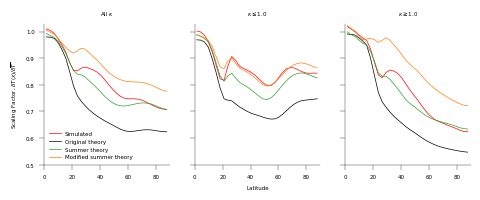

In [16]:
save_theory_lambda2_lat_fig = False
include_lambda2_theory = True
fig, ax = plt.subplots(1,3, figsize=(width['two_col'], width['two_col']/ar/(0.75*3)), sharey=True, sharex=True)
for i in range(n_sf):
    ax[i].set_title(sf_titles[i])
    for j in range(n_quant):
        ax[i].plot(lat_plot, abs_lat_av(scaling_factor['all']['simulated'][i, :, j]), color='r', alpha=quant_alpha[j],
                label='Simulated' if j==n_quant-1 else None)
        ax[i].plot(lat_plot, abs_lat_av(scaling_factor['all']['linear'][i, :, j]), color='k', alpha=quant_alpha[j],
                label='Original theory' if j==n_quant-1 else None)
        ax[i].plot(lat_plot, abs_lat_av(scaling_factor['summer']['linear'][i, :, j]), color=default_colors[2],
                   alpha=quant_alpha[j], label='Summer theory' if i==n_quant-1 else None)
        if include_lambda2_theory:
            ax[i].plot(lat_plot, abs_lat_av(scaling_factor['summer']['lambda_2'][i, :, j]), color=default_colors[1], 
                    alpha=quant_alpha[j], label='Modified summer theory' if j==n_quant-1 else None)
ax[0].set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax[1].set_xlabel('Latitude')
ax[0].legend()
ax[0].set_xlim(0,90)
ax[0].set_ylim(0.5, 1.03)
if (save_fig or save_theory_lambda2_lat_fig):
    fig.savefig(f"/Users/joshduffield/Desktop/multi_kappa_sf_theory_summer_lat.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)